In [1]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import os
import numpy as np
import matplotlib.pyplot as plt

os.chdir('../')
from function import make_data


In [2]:
# Using the provided make_data function to generate data
df = make_data(dt=0.01, total_time=50)

# Preparing the training data
train = df.iloc[:int(len(df)*0.8)]
train_x = train[['u', 'time']].values
train_y = train['f'].values

# Preparing the test data
test = df.iloc[int(len(df)*0.8):]
test_x = test[['u', 'time']].values
test_y = test['f'].values

In [3]:
def eval_inc(z, dx, gamma, beta, alpha, n):
    psi = gamma + beta * np.sign(dx * z)
    dz = dx * (1 - abs(z)**n * psi)
    df = (1 - alpha) * dx + alpha * dz
    de = z * dx

    return {
        'dz': dz,
        'df': df,
        'de': de
    }

In [4]:
from pyswarm import pso

In [5]:
train_x_diff = np.diff(train_x[:,0], axis=0)

In [6]:
train_y_diff = np.diff(train_y, axis=0)

In [7]:
def boucwen_model_sequence(u, gamma, beta, alpha, n):
    """
    Computes the dynamics of the Bouc-Wen model over a sequence of u values.
    
    Parameters:
    - u: Sequence of input values (e.g., external loading)
    - gamma, beta, alpha, n: Parameters of the Bouc-Wen model
    
    Returns:
    - z_sequence: Computed sequence of z values for the given u_sequence
    """
    z_current = 0  # Initialize z
    z_sequence = []

    for u_val in u:
        dz = bouc_wen(u_val, z_current, alpha, beta, gamma)
        z_current += dz
        z_sequence.append(z_current)

    return np.array(z_sequence)

In [8]:
def bouc_wen(u, z, alpha, beta, gamma):
    u = tf.cast(u, tf.float32)
    z = tf.cast(z, tf.float32)
    alpha = tf.cast(alpha, tf.float32)
    return u - alpha * z - beta * z * tf.abs(u) - gamma * z**2 * u

def compute_f(u, z, alpha):
    return (1 - alpha) * u + alpha * z

In [9]:
def loss_function(params):
    gamma, beta, alpha, n = params
    predictions = boucwen_model_sequence(train_x_diff, gamma, beta, alpha, n)
    mse = np.mean((predictions - train_y_diff) ** 2)
    return mse

In [10]:
lb = [-10, -10, -10, 0.1]
ub = [10, 10, 10, 2.0]    

In [12]:
optimized_params, _ = pso(loss_function, lb, ub, maxiter=10)

Stopping search: maximum iterations reached --> 10


In [13]:
gamma, beta, alpha, n = optimized_params

In [14]:
import tensorflow as tf

class PINN_NeuralODE(tf.keras.Model):
    def __init__(self, output_dim, alpha, beta, gamma):
        super(PINN_NeuralODE, self).__init__()
        self.dense1 = tf.keras.layers.Dense(32, activation='relu')
        self.dense2 = tf.keras.layers.Dense(output_dim, activation='tanh')
        self.alpha = tf.Variable(initial_value=alpha, trainable=True, dtype=tf.float32)
        self.beta = tf.Variable(initial_value=beta, trainable=True, dtype=tf.float32)
        self.gamma = tf.Variable(initial_value=gamma, trainable=True, dtype=tf.float32)

    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

    def data_loss(self, u, z_predicted, f_actual):
        f_predicted = compute_f(u, z_predicted, self.alpha)
        return tf.reduce_mean(tf.square(f_predicted - f_actual))

    def physics_loss(self, u, z_predicted):
        z_dot_predicted = bouc_wen(u, z_predicted, self.alpha, self.beta, self.gamma)
        return tf.reduce_mean(tf.square(z_dot_predicted - z_predicted))

pinn_model = PINN_NeuralODE(1, alpha, beta, gamma)

# 손실 함수 및 최적화 알고리즘 정의
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

In [15]:
@tf.function
def train_step(model, u, f):
    with tf.GradientTape() as tape:
        z_predicted = model(u)
        d_loss = model.data_loss(u, z_predicted, f)
        p_loss = model.physics_loss(u, z_predicted)
        total_loss = d_loss + p_loss
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss

In [16]:
train_x_diff = tf.cast(train_x_diff, dtype = tf.float32)
train_y_diff = tf.cast(train_y_diff, dtype = tf.float32)

train_x_diff = tf.reshape(train_x_diff, [-1, 1])
train_y_diff = tf.reshape(train_y_diff, [-1, 1])

In [17]:
EPOCHS = 100
for epoch in range(EPOCHS):
    loss = train_step(pinn_model, train_x_diff, train_y_diff)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

Epoch 0, Loss: 0.003929816652089357
Epoch 10, Loss: 0.0014409731375053525
Epoch 20, Loss: 0.0015094166155904531
Epoch 30, Loss: 0.0014196665724739432
Epoch 40, Loss: 0.0014045540010556579
Epoch 50, Loss: 0.0013966923579573631
Epoch 60, Loss: 0.001391334692016244
Epoch 70, Loss: 0.00138829683419317
Epoch 80, Loss: 0.001385642564855516
Epoch 90, Loss: 0.0013831390533596277


In [18]:
test_x_diff = np.diff(test_x[:,0], axis=0).reshape(-1,1)
test_y_diff = np.diff(test_y, axis=0).reshape(-1,1)

In [19]:
predict = pinn_model.predict(test_x_diff)

32/32 [==============================] - 0s 465us/step


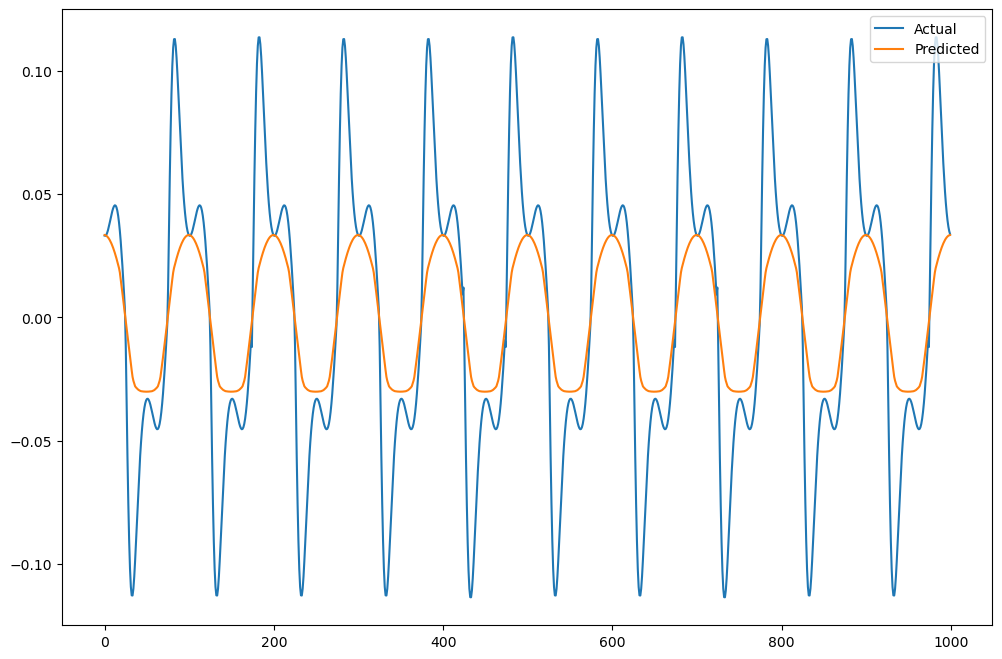

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(test_y_diff, label='Actual')
plt.plot(predict, label='Predicted')
plt.legend()
plt.show()